In [ ]:
!pip install setfit

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

In [3]:
df = (
    pd.read_csv('job_classification.csv')
    .drop(columns='Unnamed: 0')
    .rename(columns={'class_id': 'label'})
    .dropna()
)
df

,label,title,description
0,3,Airport Butler - Concierge,Requisition Number Numro de rquisition 16-078...
1,3,Los Angeles Airport - LAX - Commercial Aviatio...,"AccuFleet is looking for a ""hands-on"" operatio..."
2,3,AIRPORT POLICE OFFICER 3225,"DUTIES $62,118 to $94,732 Salary range applies..."
3,3,Airport Operations Manager,[COMPANY] is committed to being globally compe...
4,3,LAX Airport Customer Service Pool,[COMPANY] is hiring at LAX for Customer Servic...
...,...,...,...
2055,1,HEALTH FACILITIES EVALUATOR II (SUPERVISOR),Equal Opportunity Employer The State of Califo...
2056,1,Food Service Worker,Apply on Citrus Valley Health Partners gc inse...
2057,1,Public Health Nutritionist I - Supervisory,CAREER DESCRIPTION PUBLIC HEALTH NUTRITIONIST ...
2058,1,Intake Specialist - Behavioral [COMPANY]ealth ...,Job Overview Are you Bilingual in Spanish? Do ...


In [4]:
df['label'].value_counts(normalize=True)

3    0.242218
0    0.155642
5    0.155642
2    0.155156
4    0.155156
1    0.136187
Name: label, dtype: float64

In [5]:
df['description'].str.split().map(len).describe()

count    2056.000000
mean      484.623054
std       147.511159
min         1.000000
25%       467.750000
50%       544.000000
75%       573.000000
max       669.000000
Name: description, dtype: float64

In [6]:
df['text'] = df['title'] + '\n' + df['description']

In [7]:
np.random.seed(22)

train_df, test_df = train_test_split(df, test_size=.2, stratify=df['label'])
len(train_df), len(test_df)

(1644, 412)

# SetFit

In [8]:
# train_subset, _ = train_test_split(train_df, train_size=200, stratify=train_df['label'])
train_subset = train_df

train_ds = Dataset.from_pandas(train_subset)
test_ds = Dataset.from_pandas(test_df)

In [9]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [10]:
trainer.train()

***** Running training *****
  Num examples = 65760
  Num epochs = 1
  Total optimization steps = 4110
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4110 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
trainer.evaluate()

***** Running evaluation *****


{'accuracy': 0.8422330097087378}

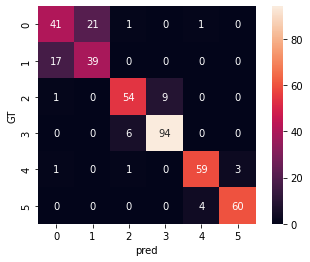

In [12]:
test_pred = trainer.model.predict(test_df.reset_index()['text'])
sns.heatmap(confusion_matrix(test_df['label'], test_pred),
            annot=True,
            square=True)
plt.xlabel('pred')
plt.ylabel('GT');

In [13]:
vectorizer = TfidfVectorizer(use_idf=False, stop_words='english')

mega_texts = train_df.groupby('label')['text'].apply(lambda texts: '\n'.join(texts))

mega_tf = vectorizer.fit_transform(mega_texts)
mega_tf = pd.DataFrame(mega_tf.todense(),
                       columns=vectorizer.get_feature_names_out()).T


pd.DataFrame({
    label: mega_tf[label].sort_values(ascending=False).index
    for label in range(6)
}).head()

,0,1,2,3,4,5
0,health,health,service,work,water,water
1,care,care,work,airport,work,resources
2,experience,services,airport,service,experience,engineering
3,company,experience,company,required,company,experience
4,patient,department,customer,company,service,design


In [14]:
(
    train_df.groupby('label')['text']
    .apply(lambda texts: texts.str.lower().str.contains('water').mean())
)

label
0    0.011719
1    0.022321
2    0.101961
3    0.057789
4    0.925490
5    0.992188
Name: text, dtype: float64

In [15]:
vectorizer = TfidfVectorizer(use_idf=True, stop_words='english', min_df=5, sublinear_tf=True)

vec_df = vectorizer.fit_transform(train_df['text'])
vec_df = pd.DataFrame(vec_df.todense(), columns=vectorizer.get_feature_names_out())

vec_df

,00,000,001,00am,00pm,01,02,03,04,06,...,year,yearly,years,yes,yield,york,youth,zealand,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.056445,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.057166,0.0,0.051857,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054875,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046957,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
chi2_df = pd.DataFrame({label: vec_df.columns[np.argsort(chi2(vec_df, train_df['label'] == label)[1])]
                        for label in range(6)}).head(20)
chi2_df

,0,1,2,3,4,5
0,clinical,health,rent,airport,water,resources
1,patients,patient,enterprise,lax,distribution,hec
2,health,department,car,water,operator,civil
3,patient,nursing,rental,wayne,wastewater,stormwater
4,care,care,hospitality,ramp,meter,engineering
5,hospital,county,airport,aircraft,meters,engineer
6,nursing,mental,guest,health,plant,modeling
7,massachusetts,nurse,lot,john,valves,hydrologic
8,baystate,community,dfw,stand,plants,water
9,therapy,medical,alamo,lift,hydrants,hydraulic


In [17]:
(
    train_df[(~train_df['text'].str.lower().str.contains('wayne')) &
             (train_df['text'].str.lower().str.contains('airport')) &
             (train_df['label'] == 3)]['text']
    .sample(1)
    .iloc[0]
)

'Airport Front Desk Receptionist Immediate Openings\n The Customer Service Rep will be responsible for taking incoming calls and emails from clients about chartering flights.  Must have great communication and follow up skills to deal with this high end clientele.  Will respond to phone and email calls and will book charters for the planes.\n'

In [18]:
(
    train_df[(train_df['text'].str.lower().str.contains('airport')) &
             (train_df['label'] == 2)]['text']
    .sample(1)
    .iloc[0]
)

'Sales Manager-Holiday Inn Orlando Airport\nEssential Job Functions  Ensures that each Guest receives outstanding Guest Service by providing a Guest friendly environment which includes greeting and acknowledging every Guest, maintaining outstanding standards, solid product knowledge and all other components of Guest Service.  Empowered to guarantee total guest satisfaction, display hospitality and professionalism to our guests at all times, take pride in representing [COMPANY] professionally with our guests and assuring that all... transactions with guests are handled in a legal and ethical manner.  Maintains a favorable working relationship with all company associates to foster and promote a positive working environment.  Expectation to dedicate significant portion of time to direct telephone solicitation sales.  New Business development for property, predominantly from Association Group Market.  Meet or exceed assigned revenue goals; Rooms, F&B, Meeting Room Rental, Incremental.  Rep

In [19]:
np.random.seed(22)

In [20]:
kws = set(sum(chi2_df.apply(list, axis=1), []))

len(kws)

107

In [21]:
chosen_kws = train_df['text'].apply(lambda text: pd.Series({kw: kw in text for kw in kws}))

chosen_kws = [col for col in chosen_kws.columns if chosen_kws[col].sum() >= 50]
len(chosen_kws)

61

In [22]:
train_df_kws = pd.concat([
    train_df,
    train_df['text'].apply(lambda text: pd.Series({f'is_{kw}': kw in text for kw in chosen_kws}))
], axis=1)

test_df_kws = pd.concat([
    test_df,
    test_df['text'].apply(lambda text: pd.Series({f'is_{kw}': kw in text for kw in chosen_kws}))
], axis=1)

print(train_df_kws.shape, test_df_kws.shape)

(1644, 65) (412, 65)


In [23]:
import torch
from tqdm.auto import tqdm
tqdm.pandas()


def extract_embedding(text):
    tokens = trainer.model.model_body.tokenizer(text, return_tensors='pt', truncation=True).to('cuda')
    return trainer.model.model_body(tokens)['sentence_embedding'].to('cpu').numpy()[0]


with torch.no_grad():
    for df in [train_df_kws, test_df_kws]:
        df['emb'] = df['text'].progress_apply(extract_embedding)

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

In [24]:
train_df_kws.T

,1316,1247,649,1447,1074,1938,353,373,1682,1672,...,1098,81,95,1605,554,559,58,1427,33,1621
label,0,0,2,0,4,1,3,3,5,5,...,4,3,3,5,2,2,3,0,3,5
title,Health Science and Recreation Department,Health Data Scientist,Dishwasher (Cat Cora's Kitchen),BEBC MEDICAL ONCOLOGISTHEMATOLOGIST,Outside Sales Representative,Health Systems Specialist,Customer Service Agent Orange County Airport,USA-Grooming Supervisor,Mid-Level Water Resources Engineer,Graduate Civil Engineer- Water Resources - Aus...,...,Unpaid / Paid Internship - Events,"Deputy Airport Director, Maintenance","Technician, Field Service (LAX - Los Angeles A...",Civil Engineer - Water Resources,Electrician - Denver International Airport,Lot Attendant - Tampa Airport,Airport Line Service Technician,Sleep Medicine Physician,Hotel Night Auditor,Water Resources Operator II
description,Health Science and Recreation Department Speci...,Apply on [COMPANY] Jobs - Recruiterbox gc inse...,HBF specializes in operating restaurants in th...,Apply on NEJM Career Center gc inserted 152337...,THE OPPORTUNITY FOR HIGH INCOME AND CAREER GRO...,None Requirements Conditions of Employment Pl...,Apply on Enterprise Careers - Enterprise Rent-...,Description Description SUMMARY: Responsible ...,[COMPANY] is seeking a motivated professional ...,Graduate Civil Engineer - Water Resources - Au...,...,"Organization: [COMPANY], Inc. Title of Positio...","CAREER DESCRIPTION DEPUTY AIRPORT DIRECTOR, MA...","Technician, Field Service (LAX - Los Angeles A...","Civil Engineer - Water Resources [COMPANY], In...",About Us Denver International Airport is the 1...,Apply on National Car Rental Jobs gc inserted ...,Full-Time Line Service Technicians Needed! Tra...,Apply on JAMA Career Center gc inserted 152337...,Apply on Aimbridge Hospitality gc inserted 152...,Description/Duties The current recruitment wil...
text,Health Science and Recreation Department\nHeal...,Health Data Scientist\nApply on [COMPANY] Jobs...,Dishwasher (Cat Cora's Kitchen)\nHBF specializ...,BEBC MEDICAL ONCOLOGISTHEMATOLOGIST\nApply on ...,Outside Sales Representative\nTHE OPPORTUNITY ...,Health Systems Specialist\nNone Requirements C...,Customer Service Agent Orange County Airport\n...,USA-Grooming Supervisor\nDescription Descript...,Mid-Level Water Resources Engineer\n[COMPANY] ...,Graduate Civil Engineer- Water Resources - Aus...,...,Unpaid / Paid Internship - Events\nOrganizatio...,"Deputy Airport Director, Maintenance\nCAREER D...","Technician, Field Service (LAX - Los Angeles A...",Civil Engineer - Water Resources\nCivil Engine...,Electrician - Denver International Airport\nAb...,Lot Attendant - Tampa Airport\nApply on Nation...,Airport Line Service Technician\nFull-Time Lin...,Sleep Medicine Physician\nApply on JAMA Career...,Hotel Night Auditor\nApply on Aimbridge Hospit...,Water Resources Operator II\nDescription/Dutie...
is_rn,True,True,False,True,False,True,True,False,True,False,...,True,False,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
is_grade,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
is_stormwater,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
is_den,True,True,False,False,False,True,True,False,True,True,...,True,True,True,True,True,False,False,False,False,True
is_rent,False,False,False,True,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,True,True


In [25]:
np.stack(train_df_kws['emb']).shape

(1644, 384)

In [26]:
train_one_hot_df = train_df_kws[[col for col in train_df_kws.columns if 'is_' in col]]
test_one_hot_df = test_df_kws[[col for col in test_df_kws.columns if 'is_' in col]]

train_features = np.concatenate([
    train_one_hot_df.values,
    np.stack(train_df_kws['emb'])
], axis=1)

test_features = np.concatenate([
    test_one_hot_df.values,
    np.stack(test_df_kws['emb'])
], axis=1)

print(train_features.shape, test_features.shape )

(1644, 445) (412, 445)


In [27]:
from sklearn.preprocessing import StandardScaler


def preprocessing(features, ss=None):
    if ss == None:
        ss = StandardScaler()
        ss.fit(features)
        
    return ss.transform(features), ss


train_features_norm, ss = preprocessing(train_features)
test_features_norm, _ = preprocessing(test_features, ss=ss)

In [28]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression()
model.fit(train_features_norm, train_df['label'])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
pred = model.predict(test_features_norm)

print('Accuracy:', np.mean(pred == test_df['label']))

Accuracy: 0.8616504854368932


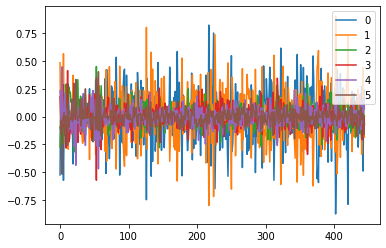

In [30]:
pd.DataFrame(model.coef_).T.plot()

In [31]:
sorted(zip(model.coef_[3][:len(chosen_kws)],
           chosen_kws))

[(-0.5703577215409789, 'stand'),
 (-0.29637382856083444, 'rent'),
 (-0.28226901621066897, 'va'),
 (-0.24293586164373135, 'den'),
 (-0.23133697854595506, 'lot'),
 (-0.22528344586387036, 'ras'),
 (-0.2175084874670085, 'engineering'),
 (-0.20755424560368976, 'engineer'),
 (-0.1936156069684952, 'noise'),
 (-0.15679525867662972, 'cars'),
 (-0.15515537687193467, 'community'),
 (-0.15189303524359007, 'guest'),
 (-0.15053973838202384, 'care'),
 (-0.14675851187554254, 'meters'),
 (-0.14311786005071897, 'hospitality'),
 (-0.13553510449969944, 'meter'),
 (-0.09516462505311496, 'hospital'),
 (-0.0951516129515182, 'resources'),
 (-0.09491674061239562, 'health'),
 (-0.0771590183718792, 'patients'),
 (-0.07651832852736595, 'airport'),
 (-0.07322014771807031, 'grade'),
 (-0.06936678582783722, 'patient'),
 (-0.06855825153332763, 'gis'),
 (-0.05574537121558484, 'vehicle'),
 (-0.05128893175286275, 'security'),
 (-0.050637104664430194, 'medical'),
 (-0.01976330667081198, 'medi'),
 (-0.0189468616237622, 'w